# Helper Functions

In [ ]:
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import os
import gdown # for downloading from google drive
import random
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
def plot_digits_with_predictions(model, data, labels, img_size=299, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)

In [ ]:
def train_test_split(X,y,test_percent):
  numRows = y.shape[0]                     #number or rows in the entire dataset
  splitPoint = int((1-test_percent)*numRows)  #the row index test_size% of the way through
  p = np.random.permutation(numRows)   #array for shuffling data
  X = X[p]
  y = y[p]

  #Training data array
  X_train = X[:splitPoint]  # training features
  y_train = y[:splitPoint]  # training labels

  #Testing data array
  X_test = X[splitPoint:]  # testing features
  y_test = y[splitPoint:] # testing labels

  y_train = np.expand_dims(y_train,1)
  y_test = np.expand_dims(y_test,1)

  return X_train, X_test, y_train, y_test

In [ ]:
def load_lungXray_data(normal_data_loc, covid_data_loc, pneumonia_data_loc=None, opacity_data_loc=None,
                                resize_shape=None, seed=42):

    data = []
    labels = []

    # Find the minimum number of images available across provided classes
    class_folders = {
        0: normal_data_loc,
        1: covid_data_loc
    }
    if pneumonia_data_loc:
        class_folders[2] = pneumonia_data_loc
    if opacity_data_loc:
        class_folders[3] = opacity_data_loc

    # Determine max samples that can be taken per class (for balancing)
    min_samples = float('inf')
    for folder in class_folders.values():
        count = len(os.listdir(folder))
        if count < min_samples:
            min_samples = count

    def load_images_from_folder(folder, label):
        images = os.listdir(folder)
        random.seed(seed)
        images = random.sample(images, min(min_samples, len(images)))

        temp_data = []
        for imgname in images:
            path = os.path.join(folder, imgname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, tuple(resize_shape)) # convert resize_shape to tuple
                img = img.flatten()
                temp_data.append(img)
        return temp_data, [label] * len(temp_data)

    for label, folder in class_folders.items():
        class_data, class_labels = load_images_from_folder(folder, label)
        data += class_data
        labels += class_labels

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

    # Find the minimum number of images available across provided classes
    class_folders = {
        0: normal_data_loc,
        1: covid_data_loc
    }
    if pneumonia_data_loc:
        class_folders[2] = pneumonia_data_loc
    if opacity_data_loc:
        class_folders[3] = opacity_data_loc

    # Determine max samples that can be taken per class (for balancing)
    min_samples = float('inf')
    for folder in class_folders.values():
        count = len(os.listdir(folder))
        if count < min_samples:
            min_samples = count

    def load_images_from_folder(folder, label):
        images = os.listdir(folder)
        random.seed(seed)
        images = random.sample(images, min(min_samples, len(images)))

        temp_data = []
        for imgname in images:
            path = os.path.join(folder, imgname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, resize_shape)
                img = img.flatten()
                temp_data.append(img)
        return temp_data, [label] * len(temp_data)

    for label, folder in class_folders.items():
        class_data, class_labels = load_images_from_folder(folder, label)
        data += class_data
        labels += class_labels

    data = np.array(data)
    labels = np.array(labels)

    return data, labels


In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)
    # print(prediction.shape)
    # print(target_output.shape)                # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches


In [ ]:
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

In [ ]:
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

In [ ]:
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

In [ ]:
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

# Download

In [ ]:
#Downloads a zip file of COVID radiographs

!gdown 1GuhIclRfMU3iS9XdTFvVR4kZ7tCI8wh6 -O covid.zip
#NOTE: this will unzip to a folder named 'images' make sure you RENAME the folder before downloading the next zip
!mkdir -p covid_images
!unzip covid.zip -d covid_images

#Downloads a zip file of normal radiographs
!gdown 1HBaa9WgG3IHFOUYUjCEch0XPDXXZW5Sz -O normal.zip
#NOTE: this will unzip to a folder named 'images' make sure you RENAME the folder before downloading the next zip
!mkdir -p normal_images
!unzip normal.zip -d normal_images

#Downloads a zip file of non-COVID infection radiographs
!gdown 1Hri6AmmgCCH0kdMRgFD_2cqp8Tn30ujk -O otherInfection.zip
#NOTE: this will unzip to a folder named 'images' make sure you RENAME the folder before downloading the next zip
!mkdir -p other_infection_images
!unzip otherInfection.zip -d other_infection_images

#Downloads a zip file of viral pneumonia radiographs
!gdown 1HPtqu6DfIVrIilX8hemjUD5CgGVmGF21 -O pneumonia.zip
#NOTE: this will unzip to a folder named 'images' make sure you RENAME the folder before downloading the next zip
!mkdir -p pneumonia_images
!unzip /content/pneumonia.zip -d pneumonia_images

Streaming output truncated to the last 5000 lines.
 extracting: other_infection_images/images/Lung_Opacity-2033.png  
  inflating: other_infection_images/images/Lung_Opacity-1587.png  
  inflating: other_infection_images/images/Lung_Opacity-5202.png  
  inflating: other_infection_images/images/Lung_Opacity-2116.png  
  inflating: other_infection_images/images/Lung_Opacity-2913.png  
  inflating: other_infection_images/images/Lung_Opacity-1204.png  
  inflating: other_infection_images/images/Lung_Opacity-5642.png  
  inflating: other_infection_images/images/Lung_Opacity-5115.png  
  inflating: other_infection_images/images/Lung_Opacity-4351.png  
 extracting: other_infection_images/images/Lung_Opacity-44.png  
  inflating: other_infection_images/images/Lung_Opacity-5912.png  
  inflating: other_infection_images/images/Lung_Opacity-5251.png  
  inflating: other_infection_images/images/Lung_Opacity-1821.png  
 extracting: other_infection_images/images/Lung_Opacity-5301.png  
  inflating: 

# Binary Classification

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)
        x = self.linear1(x)
        return x

In [ ]:
def SigmoidLoss(output, target):
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

In [ ]:
data, labels = load_lungXray_data("normal_images/images/",
                                  "covid_images/images/",
                                  "pneumonia_images/images/",
                                  "other_infection_images/images/",
                                  resize_shape=(128, 128))

In [ ]:
print(labels)

[0 0 0 ... 3 3 3]


In [ ]:
binary_labels = (labels != 0).astype(np.float32)

In [ ]:
print(binary_labels)

[0. 0. 0. ... 1. 1. 1.]


In [ ]:
healthy_indices = np.where(binary_labels == 0)[0]
unhealthy_indices = np.where(binary_labels == 1)[0]

np.random.shuffle(healthy_indices)
np.random.shuffle(unhealthy_indices)

min_class_size = min(len(healthy_indices), len(unhealthy_indices))

healthy_indices = healthy_indices[:min_class_size]
unhealthy_indices = unhealthy_indices[:min_class_size]

balanced_indices = np.concatenate((healthy_indices, unhealthy_indices))
np.random.shuffle(balanced_indices)

balanced_data = data[balanced_indices]
balanced_labels = binary_labels[balanced_indices]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(balanced_data, balanced_labels, 0.8)

In [ ]:
train_dataset = NumpyDataset(X_train, y_train)
test_dataset = NumpyDataset(X_test, y_test)

training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_dataset, batch_size=32)

Loaded Data
Epoch [1/30], Train Loss: 0.4954, Test Loss: 0.4904
Epoch [6/30], Train Loss: 0.4896, Test Loss: 0.4866
Epoch [11/30], Train Loss: 0.4879, Test Loss: 0.4865
Epoch [16/30], Train Loss: 0.4873, Test Loss: 0.4863
Epoch [21/30], Train Loss: 0.4867, Test Loss: 0.4865
Epoch [26/30], Train Loss: 0.4873, Test Loss: 0.4863


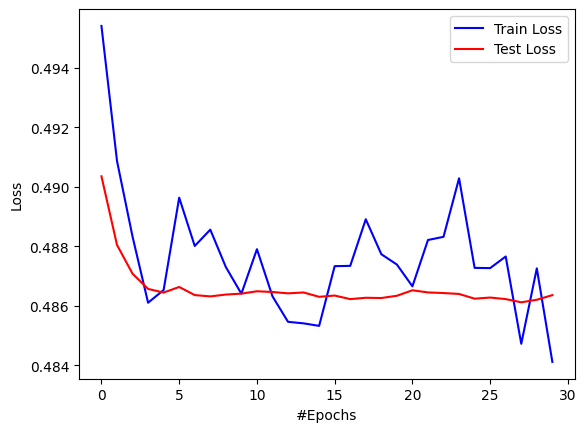

In [ ]:
num_epochs = 30
print_interval = 5
learning_rate = 0.0000001

img_w = 128
img_h = 128
numClasses = 1

model = LinearClassifier(img_w, img_h, numClasses)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = SigmoidLoss

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 275/537 (51.2%)

Train Set: Accuracy: 1094/2153 (50.8%)


AUC: 0.5384643263953608
Precision [0.61052632 0.50340136]
Recall [0.0537037  0.96551724]
F1 [0.0987234 0.6617694]
Count [1080 1073]


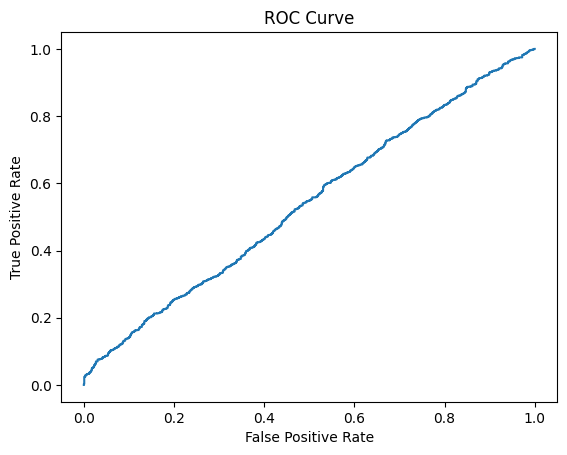

In [ ]:
preds = model(torch.tensor(X_test).float()).detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(y_test,preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(y_test,preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

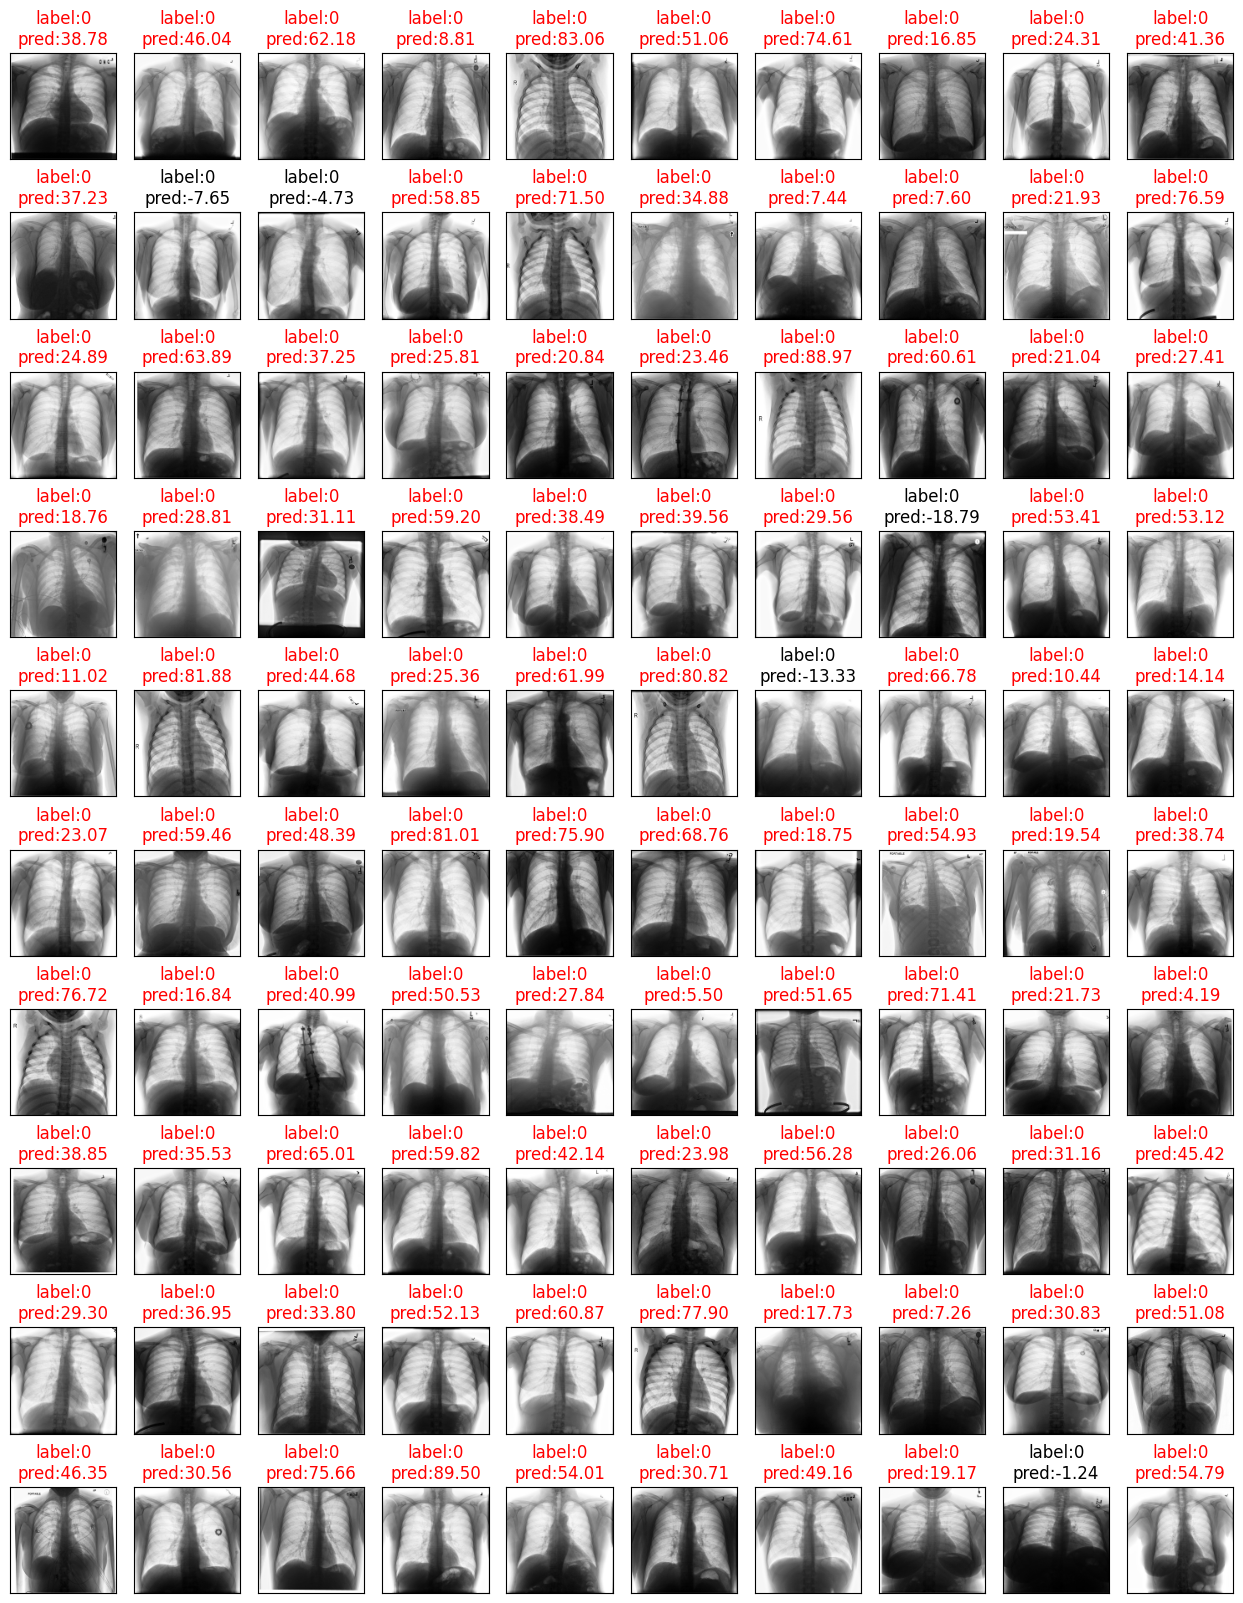

In [ ]:
plot_digits_with_predictions(model, data, labels, img_size=128, rows=10)

# Other Binary Classification

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def evaluate_model(name, y_true, preds, probs):
    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    roc = roc_auc_score(y_true, probs)
    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    return acc, f1, roc

In [ ]:
def plot_digits_with_predictions_v2(model, data, labels, img_size=299, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model.predict(data[i].reshape(1, -1))[0]
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)

In [ ]:
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

svm_preds = svm_model.predict(X_test)
svm_probs = svm_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
acc_svm, f1_svm, roc_svm = evaluate_model("SVM", y_test, svm_preds, svm_probs)


SVM Evaluation:
Accuracy: 0.8119
F1 Score: 0.8122
ROC AUC: 0.9021


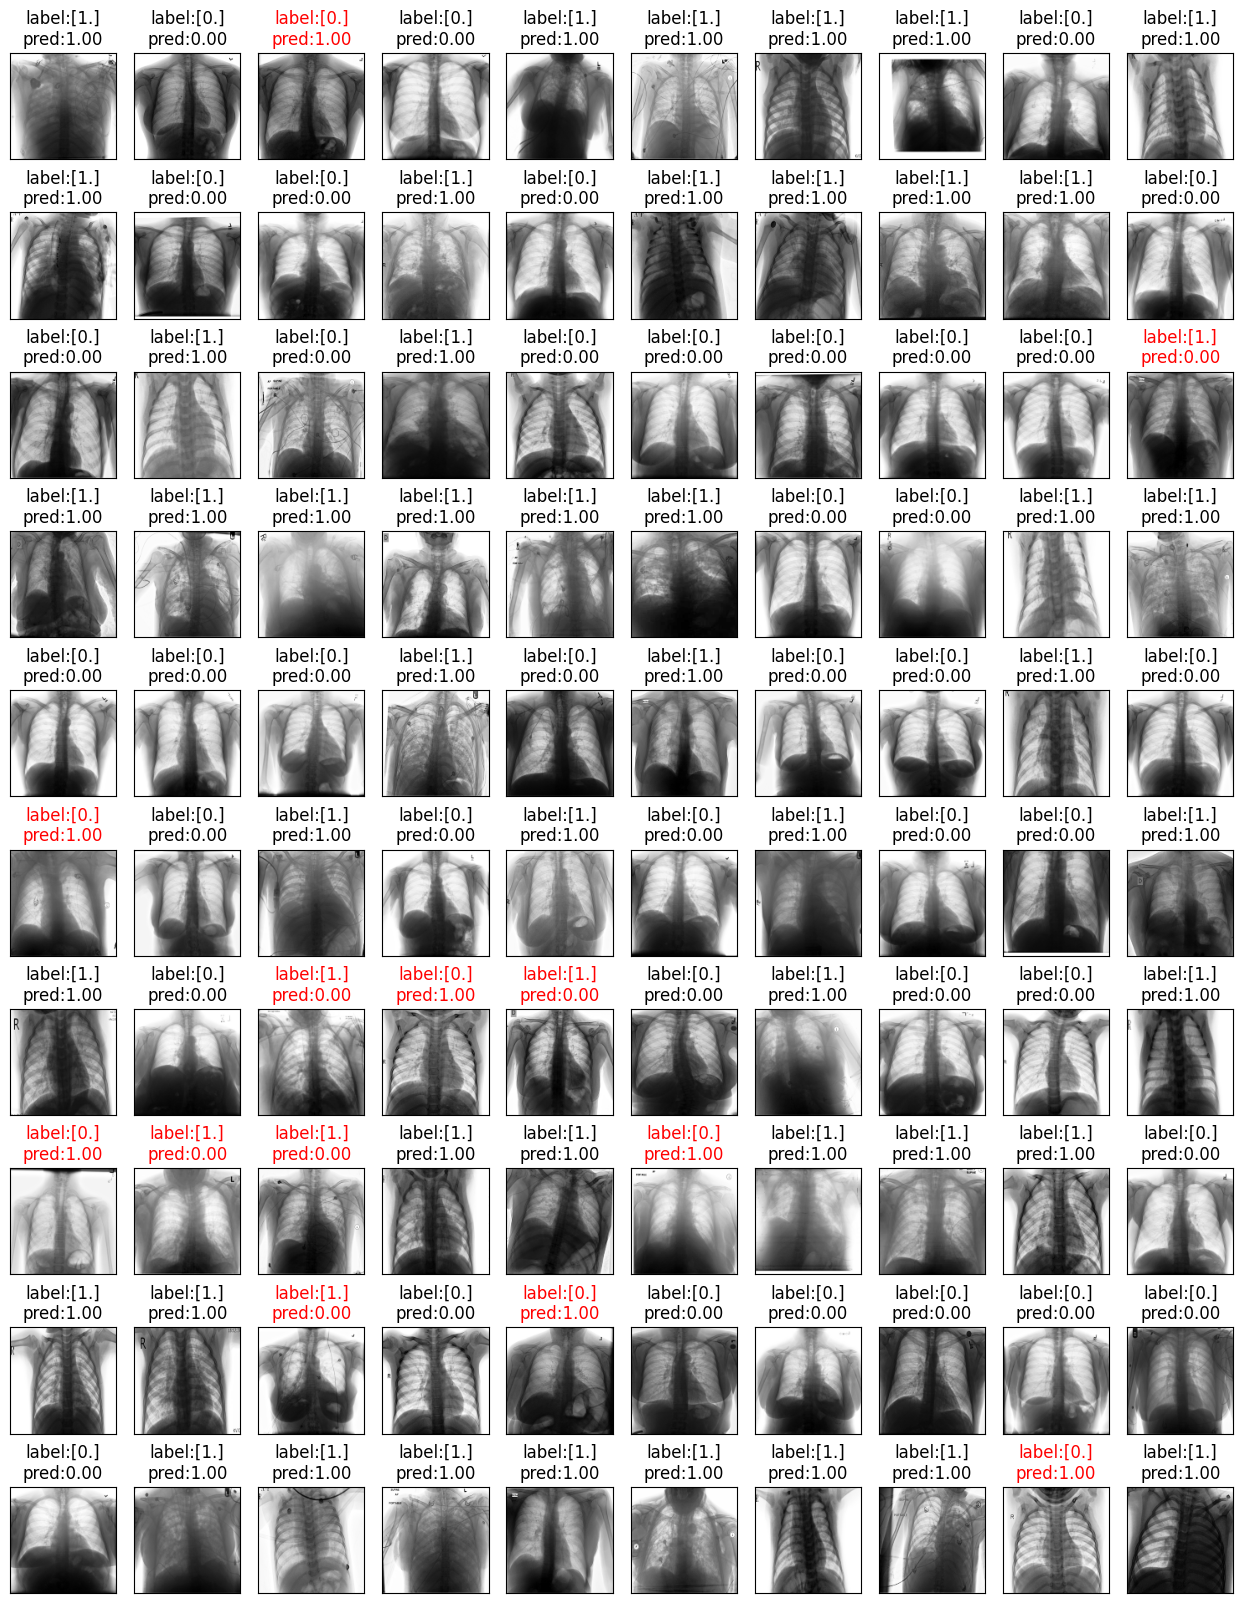

In [ ]:
plot_digits_with_predictions_v2(svm_model, X_test, y_test, img_size=128, rows=10)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
acc_rf, f1_rf, roc_rf = evaluate_model("Random Forest", y_test, rf_preds, rf_probs)


Random Forest Evaluation:
Accuracy: 0.8068
F1 Score: 0.8083
ROC AUC: 0.8949


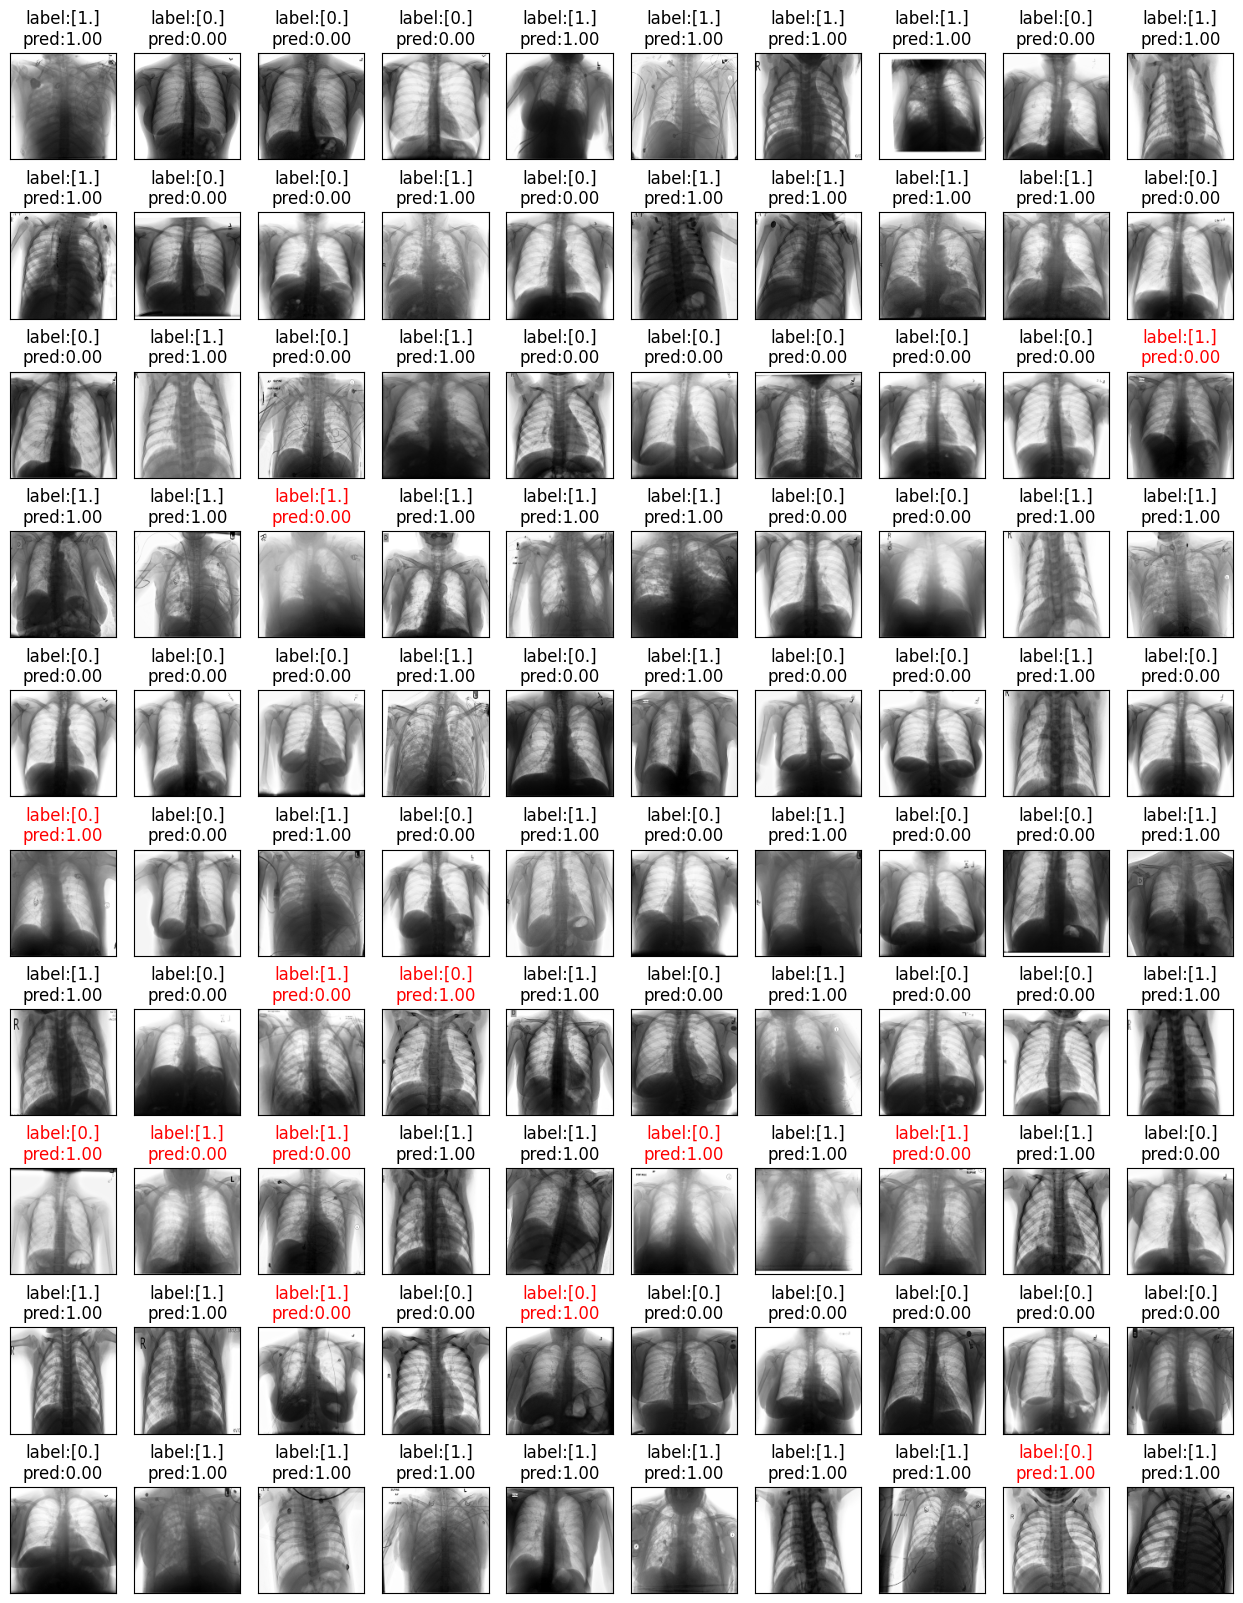

In [ ]:
plot_digits_with_predictions_v2(rf_model, X_test, y_test, img_size=128, rows=10)

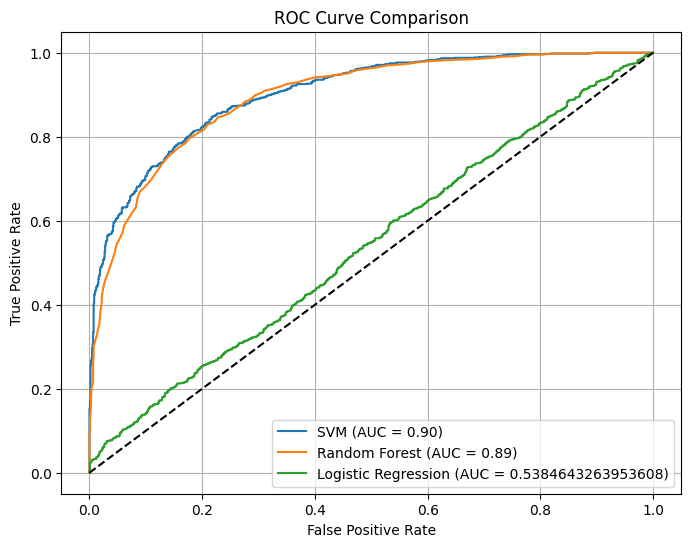

In [ ]:
from sklearn.metrics import roc_curve

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_svm:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_rf:.2f})')
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {metrics.auc(fpr, tpr)})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


# Specific Diagnosis Classification

In [ ]:
import torch.nn.functional as F #

In [ ]:
def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #NEW: Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
class Classifier_4Layers(nn.Module):
    def __init__(self, img_w, img_h, numClasses):
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 32)
        self.linear4 = nn.Linear(32, 16)
        self.linear5 = nn.Linear(16, 8)
        self.linear6 = nn.Linear(8, numClasses)


    def forward(self, x):
        x = x.view(-1, self.flatSize)
        x = F.relu(self.linear1(x))
        x = torch.abs(self.linear2(x))
        x = self.linear3(x)
        x = F.relu(self.linear4(x))
        x = self.linear5(x)
        x = torch.abs(self.linear6(x))
        return x

In [ ]:
labels_one_hot = F.one_hot(torch.from_numpy(labels.astype(int)).long())

X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, 0.2)

train_dataset = NumpyDataset(X_train, y_train.squeeze())
test_dataset = NumpyDataset(X_test, y_test.squeeze())

Loaded Data
Epoch [1/30], Train Loss: 1.1540, Test Loss: 0.9215
Epoch [6/30], Train Loss: 0.7181, Test Loss: 0.6984
Epoch [11/30], Train Loss: 0.6458, Test Loss: 0.6373
Epoch [16/30], Train Loss: 0.6008, Test Loss: 0.6247
Epoch [21/30], Train Loss: 0.5512, Test Loss: 0.7186
Epoch [26/30], Train Loss: 0.5142, Test Loss: 0.5709


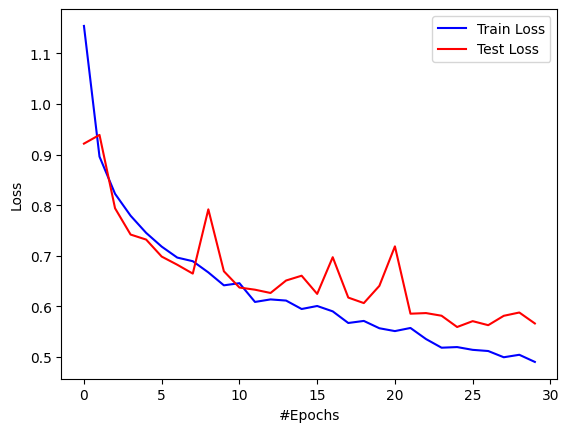

In [ ]:
num_epochs = 30
print_interval = 5
learning_rate = 0.00001
batch_size = 32

img_w = 128
img_h = 128
numClasses = 4

model = Classifier_4Layers(img_w, img_h, numClasses)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 3559/4304 (82.7%)

Train Set: Accuracy: 814/1076 (75.7%)


# Visual Analysis


In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

class_names = ['Normal', 'COVID', 'Pneumonia', 'Other Infection']

def get_most_confident_images(model, data_loader, class_names, img_h, img_w):
    model.eval()
    most_confident = {}
    confidences = {}

    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            probs = F.softmax(output, dim=1)
            confs, preds = probs.max(dim=1)
            true_labels = target.max(1)[1]

            for i in range(len(preds)):
                label = true_labels[i].item()
                pred = preds[i].item()
                confidence = confs[i].item()

                if pred == label:
                    if label not in confidences or confidence > confidences[label]:
                        confidences[label] = confidence
                        most_confident[label] = data[i]

    num_classes = len(class_names)
    fig, axs = plt.subplots(1, num_classes, figsize=(4 * num_classes, 4))

    for label in range(num_classes):
        if label in most_confident:
            axs[label].imshow(most_confident[label].view(img_h, img_w), cmap='gray')
            axs[label].set_title(f"{class_names[label]}\nConf: {confidences[label]:.2f}")
        else:
            axs[label].set_title(f"{class_names[label]}\nNo Correct Prediction")
        axs[label].axis('off')

    plt.tight_layout()
    plt.show()


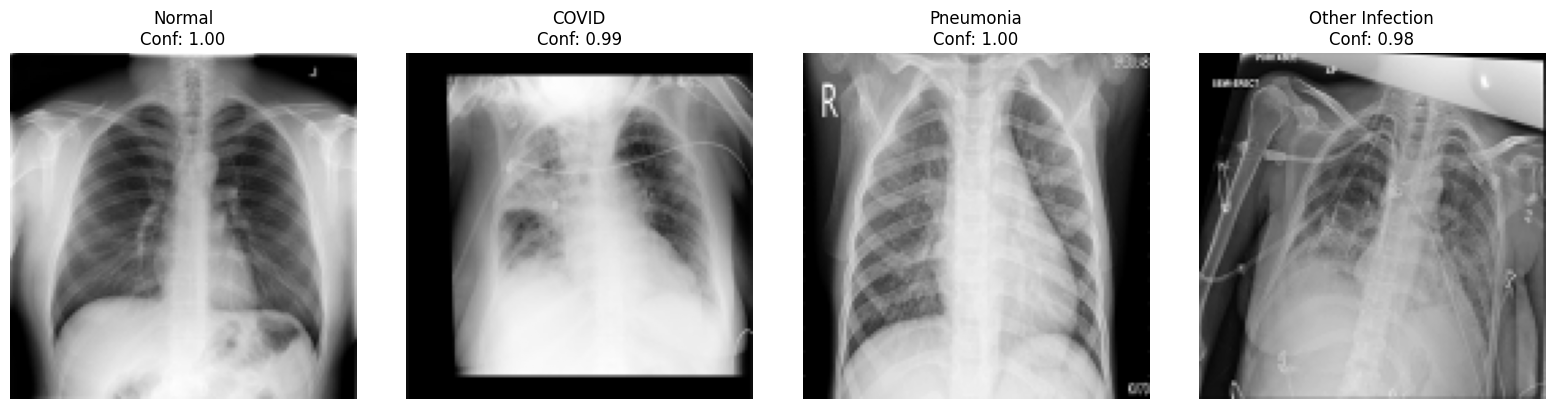

In [ ]:
get_most_confident_images(model, testing_generator, class_names,  img_h=128, img_w=128)

Text(70.72222222222221, 0.5, 'Predicted Class')

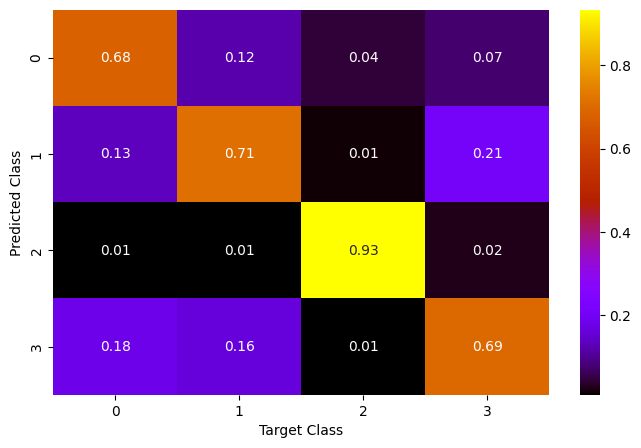

In [ ]:
data_generator = torch.utils.data.DataLoader(test_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images)
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1]
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "gnuplot")
plt.xlabel("Target Class")
plt.ylabel("Predicted Class")

In [ ]:
from collections import defaultdict

def get_misclassified_images(model, data_loader, class_names, num_examples=1):
    model.eval()
    misclassified = defaultdict(list)

    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            preds = output.argmax(dim=1)
            true = target.argmax(dim=1)

            for i in range(len(preds)):
                if preds[i] != true[i]:
                    key = (true[i].item(), preds[i].item())
                    misclassified[key].append(data[i])

    sorted_misclassified = sorted(misclassified.items(), key=lambda x: len(x[1]), reverse=True)

    for (true_label, pred_label), images in sorted_misclassified[:3]:
        for img in images[:num_examples]:
            plt.imshow(img.view(img_h, img_w), cmap='gray')
            plt.title(f"True: {class_names[true_label]} | Predicted: {class_names[pred_label]}")
            plt.axis('off')
            plt.show()

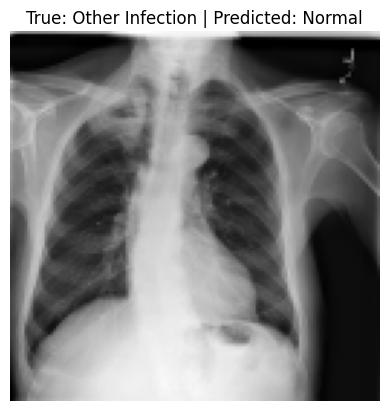

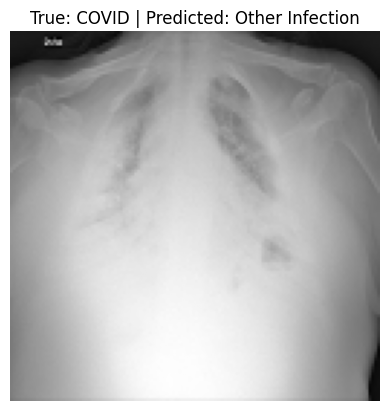

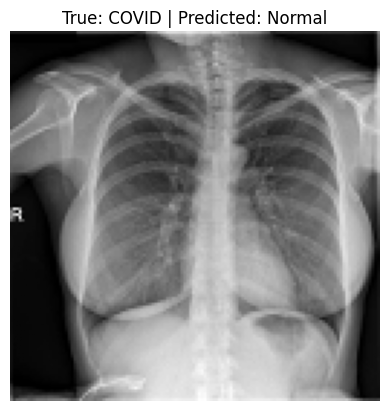

In [ ]:
class_names = ['Normal', 'COVID', 'Pneumonia', 'Other Infection']
get_misclassified_images(model, testing_generator, class_names)